## When would we use logistic regression?

Logistic regression can be used if the dependent variable is categorical (e.g. a binary 0 or 1). If the dependent variable is continuous, then linear regression can be used to predict a value for the response variable.

#### The first question that comes to mind is -- why can't we just use linear regression and use the y value as a probability?

Let's try this out with a linear regression model to see why.

$$h_{\theta}(x) = \theta^{T} X$$

First, let's import some categorical data. Again, I'm using data from Andrew Ng's course --
http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex4/ex4.html

The features are scores from 2 exams taken by 80 high school students. The dependent variable is whether the student was accepted into a university or not.

In [29]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
%matplotlib inline

import seaborn as sns 
sns.set_context('talk')
sns.set_style('darkgrid')

In [2]:
exam_scores_df = pd.read_table('exam_scores.dat', header=None, sep='\s+')
exam_scores_df.columns = ['exam_one', 'exam_two']
admitted_df = pd.read_table('admitted.dat', header=None, sep='\s+')
admitted_df.columns = ['admitted']

In [3]:
df = exam_scores_df.join(admitted_df)

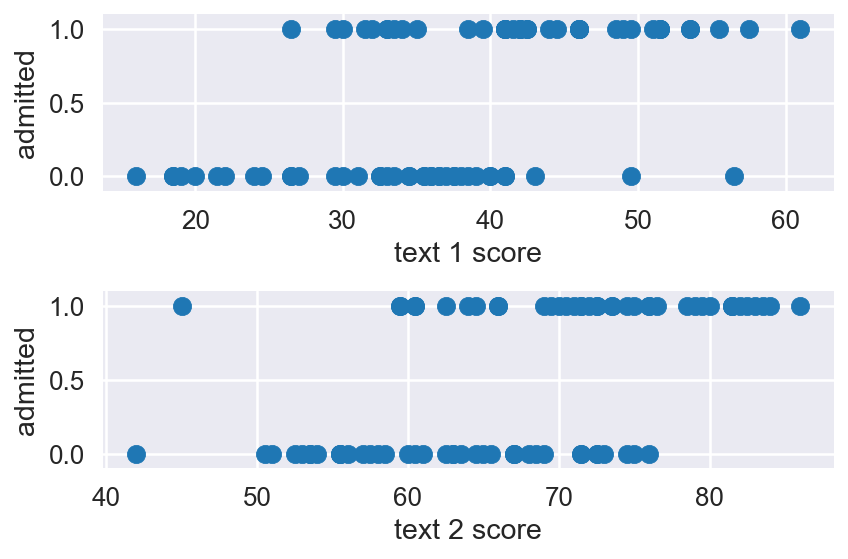

In [4]:
plt.subplot(211)
plt.scatter(df.exam_one, df.admitted)
plt.xlabel('text 1 score')
plt.ylabel('admitted')
plt.subplot(212)
plt.scatter(df.exam_two, df.admitted)
plt.xlabel('text 2 score')
plt.ylabel('admitted')
plt.tight_layout()
plt.show()

In [5]:
def hypothesis(thetas, xs):
    return np.dot(thetas, xs)

def cost_function(thetas, xs, ys):
    m = len(xs)
    return (1 / (2 * m)) * sum((np.array(ys) - hypothesis(thetas, xs))**2)

def gradient_descent_update(thetas, xs, ys):
    learning_rate = 0.000001
    m = len(xs)
    new_thetas = np.empty(len(thetas))
    for j, theta in enumerate(thetas):
        new_thetas[j] = theta - (learning_rate * (1 / m) * sum((hypothesis(thetas, xs) - ys) * xs[j]))
    return new_thetas

def minimize(*args, **kwargs):
    ys = kwargs['ys']
    xs = [np.ones(len(ys))]
    for arg in args:
        xs.append(arg)
    xs = np.array(xs)
    costs = []
    input_thetas = kwargs.get('thetas')
    thetas = input_thetas if input_thetas is not None else np.zeros(len(xs))
    for i in range(100):
        costs.append(cost_function(thetas, xs, ys))
        thetas = gradient_descent_update(thetas, xs, ys)
    return {'costs': costs, 'thetas': thetas}

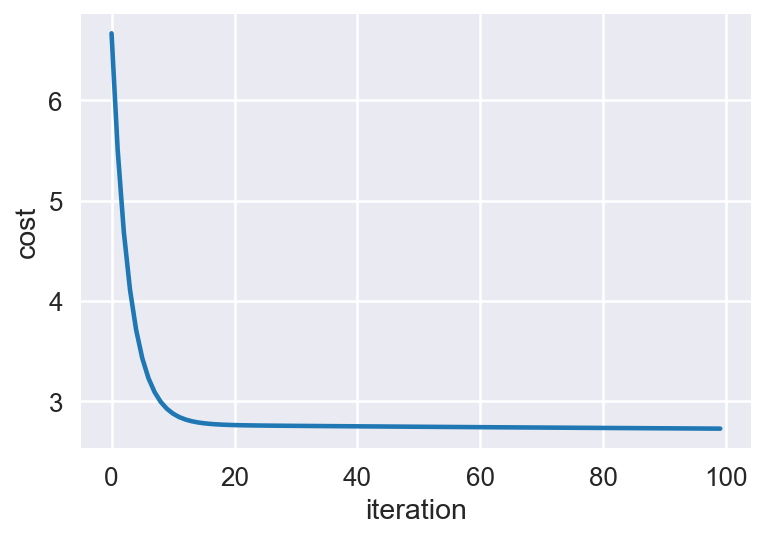

In [6]:
exam_one_xs, exam_two_xs, ys = df.values.T
result = minimize(exam_one_xs, exam_two_xs, ys=ys)
plt.plot(result['costs'])
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

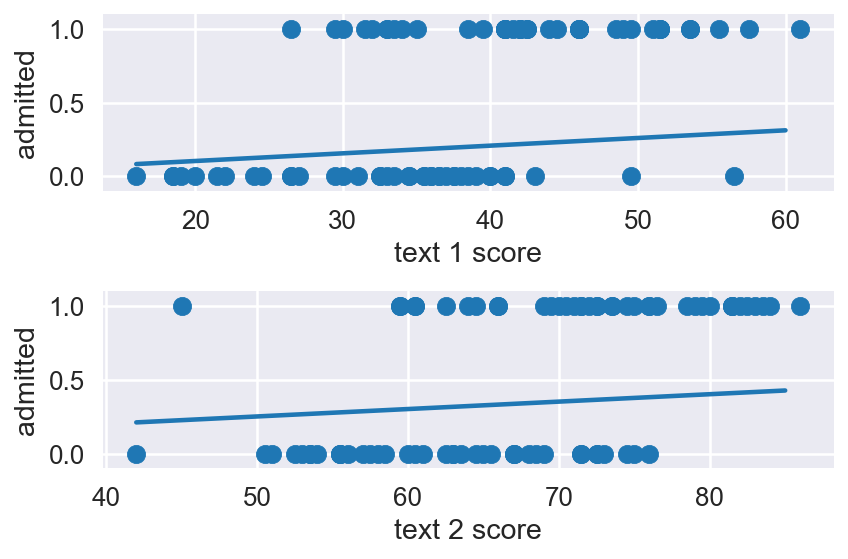

In [7]:
plt.subplot(211)
plt.scatter(x=df.exam_one, y=df.admitted)
line_xs = range(int(df.exam_one.min()), int(df.exam_one.max()))
line_ys = [((x*result['thetas'][1]) + result['thetas'][0]) for x in line_xs]
plt.plot(line_xs, line_ys)
plt.xlabel('text 1 score')
plt.ylabel('admitted')

plt.subplot(212)
plt.scatter(x=df.exam_two, y=df.admitted)
line_xs = range(int(df.exam_two.min()), int(df.exam_two.max()))
line_ys = [((x*result['thetas'][2]) + result['thetas'][0]) for x in line_xs]
plt.plot(line_xs, line_ys)
plt.xlabel('text 2 score')
plt.ylabel('admitted')
plt.tight_layout()
plt.show()

There are a few problems with this approach. Here, $y$ does not truly correspond to a probability of successfully being admitted (neither value is > 0.5 within this range). It is also possible for $y$ to span values outside of (0, 1), which also would also make $y$ uninterpretable as a probability.

Also, a linear model using ordinary least squares fundamentally makes some assumptions about the data that is invalid for a binary response variable.

1. The dependent variable has a linear relationship with the independent variable.
2. For any given input X, the response Y is independent and roughly normally distributed.
3. The probability distribution of Y has the same standard deviation.
  - In other words, the distribution of $\varepsilon$, i.e. the variance of the data that cannot be explained by the linear model is constant

None of the above is true if the response is binary. Least squares estimation is not capable of producing
minimum variance unbiased estimators for the parameters in the linear model.

## Enter the generalized linear model (GLM) and the logit link function

The GLM is a generalization of linear regression that allows us to combine a linear predictor with error distribution models other than the normal distribution. The relationship between the linear model and the response variable is defined with a _link function_, which is a function $g(p)$ of the probability of a given outcome on the dependent variable.

Logistic regression uses the "logit" link function.

$$g(p) = ln\left(\frac{p}{1-p}\right)$$

This function addresses two aspects of the data.
1. The conditional distribution $y \mid x$ is a Bernoulli distribution rather than a Gaussian distribution because the dependent variable is binary.
2. The predicted values are probabilities and are therefore restricted to (0,1).

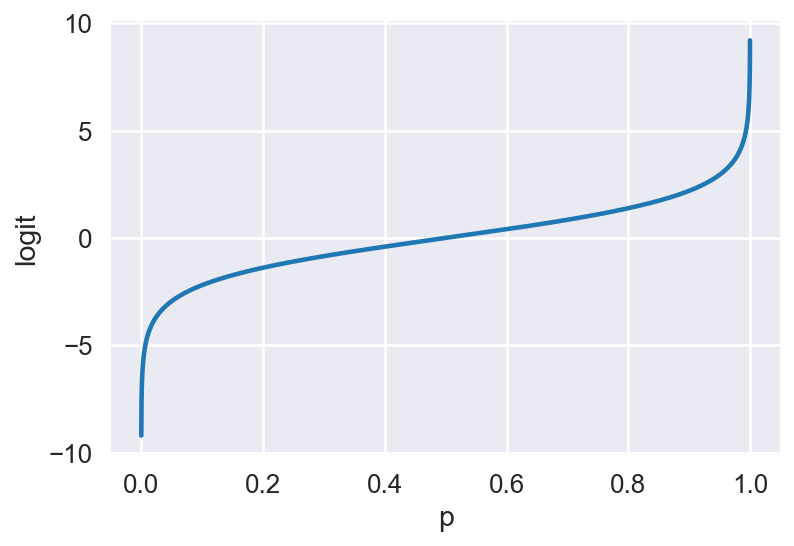

In [30]:
logit = lambda p: math.log(p / (1 - p))
xs = np.arange(0.0001, 1, 0.0001)
ys = tuple(map(logit, xs))
plt.plot(xs, ys)
plt.xlabel('p')
plt.ylabel('logit')
plt.show()

What this shows is that the output of a linear model can produce any real output and the logit will map it to a probability value that is bounded between 0 and 1. The $p / (1 - p)$ can also be interpretted as the odds. And so the logit transform is the natural logarithm of the odds that some event will occur.

$$g(\text{odds}) = ln(\text{odds})$$
where
$$\text{odds} = \frac{P(Y=1)}{P(Y=0)} = \frac{P(Y=1)}{1 - P(Y=1)} = \frac{p}{1 - p}$$.

Below I've plotted how $p$ maps to the odds, and how the odds maps to the logit.

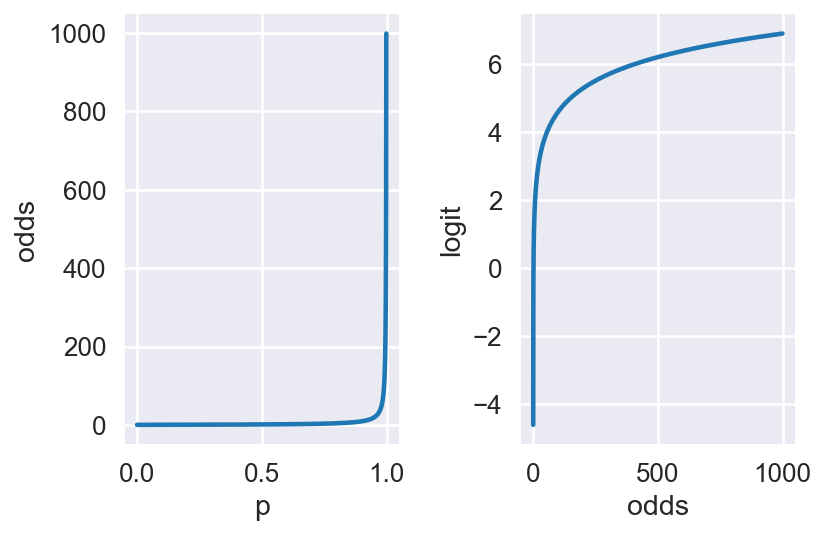

In [41]:
plt.subplot(121)
odds = lambda p: p / (1 - p)
xs = np.arange(0.001, 1, 0.001)
ys = tuple(map(odds, xs))
plt.plot(xs, ys)
plt.xlabel('p')
plt.ylabel('odds')
plt.subplot(122)
logit = lambda odds: math.log(odds)
xs = np.arange(0.01, 1000, 0.1)
ys = tuple(map(logit, xs))
plt.plot(xs, ys)
plt.xlabel('odds')
plt.ylabel('logit')
plt.tight_layout()
plt.show()

## Logistic regression

The the formula below for logistic regression is shown with the logit link function on the left and the linear predictor on the right.

$$ln(\text{odds}) = ln(\frac{p}{1-p}) = \theta_{0}x_{0} + \theta_{1}x_{1} + \ldots + \theta_{n-1}x_{n-1} + \theta_{n}x_{n} = \theta^{T}X$$

The probability $p = P(Y=1)$ solves to

$$\frac{p}{1-p} = e^{\theta^{T}X}$$
$$p = (1 - p)e^{\theta^{T}X}$$
$$p = e^{\theta^{T}X} - pe^{\theta^{T}X}$$
$$p + pe^{\theta^{T}X} = e^{\theta^{T}X}$$
$$p(1 + e^{\theta^{T}X}) = e^{\theta^{T}X}$$
$$p = \frac{e^{\theta^{T}X}}{e^{\theta^{T}X} + 1}$$
$$p = \frac{1}{1 + e^{- \theta^{T}X}}$$

## Hypothesis function

Let's tie this back to Andrew Ng's course. The hypothesis function $h_{\theta}(x)$ is the estimated probability that $Y = 1$ given an input $x$ parameterized by $\theta$.

$$h_{\theta}(X) = P(Y=1 \mid X ; \theta) = \frac{1}{1 + e^{- \theta^{T}X}}$$

This predicts that $y = 1$ when $h_{\theta}(X) \ge 0.5$, and $y = 0$ when $h_{\theta}(X) \lt 0.5$.

This also translates to the prediction that $y = 1$ when $\theta^{T}X \ge 0$, and $y = 0$ when $\theta^{T}X \lt 0$. The decision boundary can therefore be solved (given values for $\theta$) by setting $\theta^{T}X = 0$. Also, it's worth noting that this decision boundary does not need to linear; one can introduce higher order features to make functions that describe non-linear shapes, e.g. circles ($\theta_{0} + \theta_{1}x_{1}^{2} + \theta_{2}x_{2}^{2}$).

## Cost function

We can't use a linear regression cost function (with square errors) because it is a non-convex function of the parameters. That is, if we use

$$J(\theta) = \frac{1}{m} \sum \text{Cost}(h(\theta), y) \\
= \frac{1}{m} \sum \frac{1}{2} \left(h(\theta) - y \right)^{2} \\
= \frac{1}{m} \sum \frac{1}{2} \left(\frac{1}{1 + e^{\theta^{T}X}} - y \right)^{2}$$

for the cost function, it will have many local minima and is not guaranteed to converge on the global minimum. Instead, the cost function that is used is log loss.

$$\text{Cost}(h(\theta), y) = \begin{cases}
            - \log(h_{\theta}(x)) & \text{if $y = 1$} \\
            - \log(1 - h_{\theta}(x)) & \text{if $y = 0$}
        \end{cases}$$

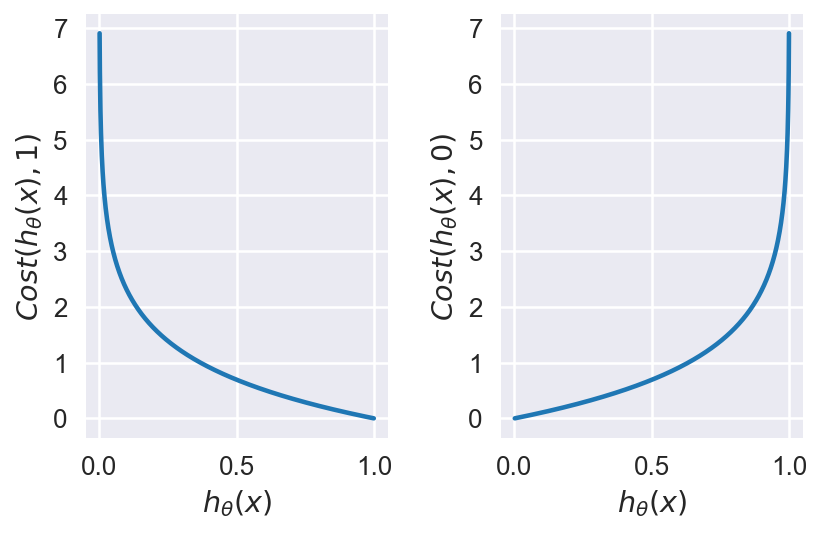

In [57]:
plt.subplot(121)
cost = lambda h: - math.log(h)
xs = np.arange(0.001, 1, 0.001)
ys = tuple(map(cost, xs))
plt.plot(xs, ys)
plt.xlabel(r'$h_{\theta}(x)$')
plt.ylabel(r'$Cost(h_{\theta}(x), 1)$')
plt.subplot(122)
cost = lambda h: - math.log(1 - h)
ys = tuple(map(cost, xs))
plt.plot(xs, ys)
plt.xlabel(r'$h_{\theta}(x)$')
plt.ylabel(r'$Cost(h_{\theta}(x), 0)$')
plt.tight_layout()
plt.show()

What these plots show is that the higher the probability is for an incorrect prediction, the more it is penalized. The overall cost function $J_{\theta}(x)$ will be convex and local-optima-free when these two costs are combined, where $y \in \{0, 1\}$.

$$J_{\theta}(x) = \frac{1}{m} \sum_{i=0}^{m}\left[ - y^{(i)} \log(h_{\theta}(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)})) \right]$$

This cost function can be derived from the principle of maximum likelihood estimation. I'll go into that next.

## Maximum likelihood estimation

Just like in the case of OLS, we want to define a likelihood function ($L(\theta)$) for accurate predictions by the model for the observed independent variables. We know so far that.

$$P(Y=1 \mid x ; \theta) = h_{\theta}(x)$$
$$P(Y=0 \mid x ; \theta) = 1 - h_{\theta}(x)$$

More compactly, this reduces to

$$p(y \mid x; \theta) = (h_{\theta}(x))^{y} (1 - h_{\theta}(x))^{1 - y}$$

Again, if we assume independence again we can expand the likelihood function to be a product of the probabilities for $m$ observations.

$$L(\theta) = p(\vec{y} \mid X; \theta) \\ 
= \prod_{i=1}^{m} p(y^{(i)} \mid x^{(i)}; \theta) \\
= \prod_{i=1}^{m} (h_{\theta}(x^{(i)}))^{y^{(i)}} (1 - h_{\theta}(x^{(i)}))^{1 - y^{(i)}}$$

And again, we use the trick of taking the log of the likelihood to make the math convenient.

$$\ell(\theta) = \log L(\theta) \\
= \sum_{i=1}^{m} y^{(i)}\log(h_{\theta}(x^{(i)})) + (1 - y^{(i)})\log(1 - h_{\theta}(x^{(i)}))$$

One way to solve logistic regression is to simply maximize the log likelihood with a method known as stochastic gradient ascent, for which the update rule would be

$$\theta := \theta + \alpha \nabla_{\theta} \ell(\theta)$$

which gives us

$$\theta_{j} := \theta_{j} + \alpha \left(y^{(i)} - h_{\theta}(x^{(i)}) \right) x^{(i)}_{j}$$

. Further below, I will go into Newton's method, which is another way to solve logistic regression.



## Interpretation of the coefficients

In linear regression, the regression coefficients represent the sensitivity of the response variable to changes in the linear predictor. In logistic regression, however, the regression coefficients represent the sensitivity of the logit to changes in the linear predictor. The logit is a little difficult to intuit through, so it is convenient to instead think of this with the odds ratio($\Delta\text{odds}$). Given that,

$$ln(\text{odds}) = \theta^{T}X$$
$$\text{odds} = e^{\theta^{T}X}$$

then

$$\Delta\text{odds} = \frac{\text{odds}(x_{i}+1)}{\text{odds}(x_{i})} = \frac{e^{\theta_{0}x_{0} + \ldots + \theta_{i}(x_{i} + 1) + \ldots + \theta_{n}x_{n}}}{e^{\theta_{0}x_{0} + \ldots + \theta_{i}x_{i} + \ldots + \theta_{n}x_{n}}} = e^{\theta_{i}}$$

.

This provides an interpretation for $\theta_{i}$: the odds of $Y=1$ increases by a factor of $e^{\theta_{i}}$ for every 1-unit increase in $x_{i}$.

## Update rule for Newton's method

This is the update rule.

$$\theta^{(t + 1)} = \theta^{(t)} - H^{-1}\nabla_{\theta}J$$

The gradient and Hessian are

$$\nabla_{\theta}J = \frac{1}{m}\sum_{i=1}^{m}\left(h_{\theta}(x^{(i)}) - y^{(i)}\right)x^{(i)}$$
$$H = \frac{1}{m}\sum_{i=1}^{m}\left[h_{\theta}(x^{(i)})\left(1 - h_{\theta}(x^{(i)})\right)x^{(i)}\left(x^{(i)}\right)^{T}\right]$$

## The Bayesian interpretation of regularization

Instead of maximizing the likelihood probability (of the data $y$ given a model, $x$ parameterized by $\theta$), we can also view the problem of finding the best $\theta$ as one of maximizing the posterior probability of the model ($x$ parameterized by $\theta$) given the data ($y$).

$$P(\theta \mid y) = \frac{P(y \mid \theta)P(\theta)}{P(y)}$$

And we take the $\log$ again

$$\ln P(\theta \mid y) = \ln{P(y \mid \theta)} + \ln{P(\theta)} - \ln{P(y)}$$